## Tutorial 3: Time Series Statsitics

In this tutorial, we visualize time-dependent statistics of the price data, including:
* Moving averages with different smoothing 
* Correlation among stocks
* Value-at-Risk

In [168]:
import pandas as pd
import numpy as np
import scipy
import scipy.stats
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["Times New Roman"]

In [169]:
# get all path names
import os
dir_name = "./data/"
file_names = [f for f in os.listdir(dir_name) if not f.startswith('.')]
TICKERS = [None] * len(file_names)
start_date, end_date = None, None
# extract tickers
for k in range(len(file_names)):
    tmp = file_names[k].split("_")
    tk = tmp[0]
    if start_date is None:
        start_date = tmp[1]
    if end_date is None:
        end_date = tmp[-1].split(".")[0]
    TICKERS[k] = tk
print("> Date range = {} TO {}".format(start_date, end_date))
print("> Tickers = {}".format(TICKERS))

> Date range = 2015-04-30 TO 2024-04-30
> Tickers = ['IBM', 'INTC', 'TSLA', 'QCOM', 'NVDA', 'META', 'AVGO', 'TCEHY', 'ORCL', 'AMZN', 'GOOG', 'MSFT', 'AAPL', 'TSM', 'CRM', 'BABA', 'CSCO', 'ADBE']


In [170]:
n = len(TICKERS)
price_data = {}
for k in range(n):
    tk = TICKERS[k]
    fname = file_names[k]
    # load data
    tmp = dir_name + "/" + fname
    data = pd.read_csv(tmp)
    assert not data.isnull().values.any()
    # use adjusted close 
    date = data["Date"]
    price = data["Adj Close"]
    # compute price changes
    price_data[tk] = (
        date, price
    )

Below we plot an example smoothing with simple moving average. For forecasting, to avoid look-ahead bias, we need to set `min_periods=1` and `closed="left"` to ignore the last point in the window. 

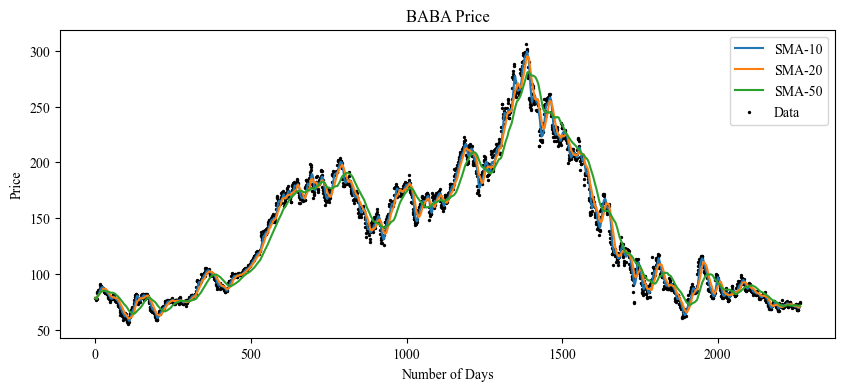

In [171]:
tk = "BABA"
p = price_data[tk][1]
sma10 = p.rolling(10, min_periods=1).mean()
sma20 = p.rolling(20, min_periods=1).mean()
sma50 = p.rolling(50, min_periods=1).mean()

plt.figure(1, figsize=(10, 4));
plt.plot(sma10, label="SMA-10"); 
plt.plot(sma20, label="SMA-20"); 
plt.plot(sma50, label="SMA-50"); 
plt.scatter(range(len(p)), p, s=2, color="black", label="Data");
plt.title(tk + " Price"); 
plt.xlabel("Number of Days"); plt.ylabel("Price");
plt.legend(); 

### Moving average of all stocks

We examine two smoothers with the same number of lookback periods: (1) simple moving average and (2) exponential moving average with comparable average decay of $1/\tau$ number of days.

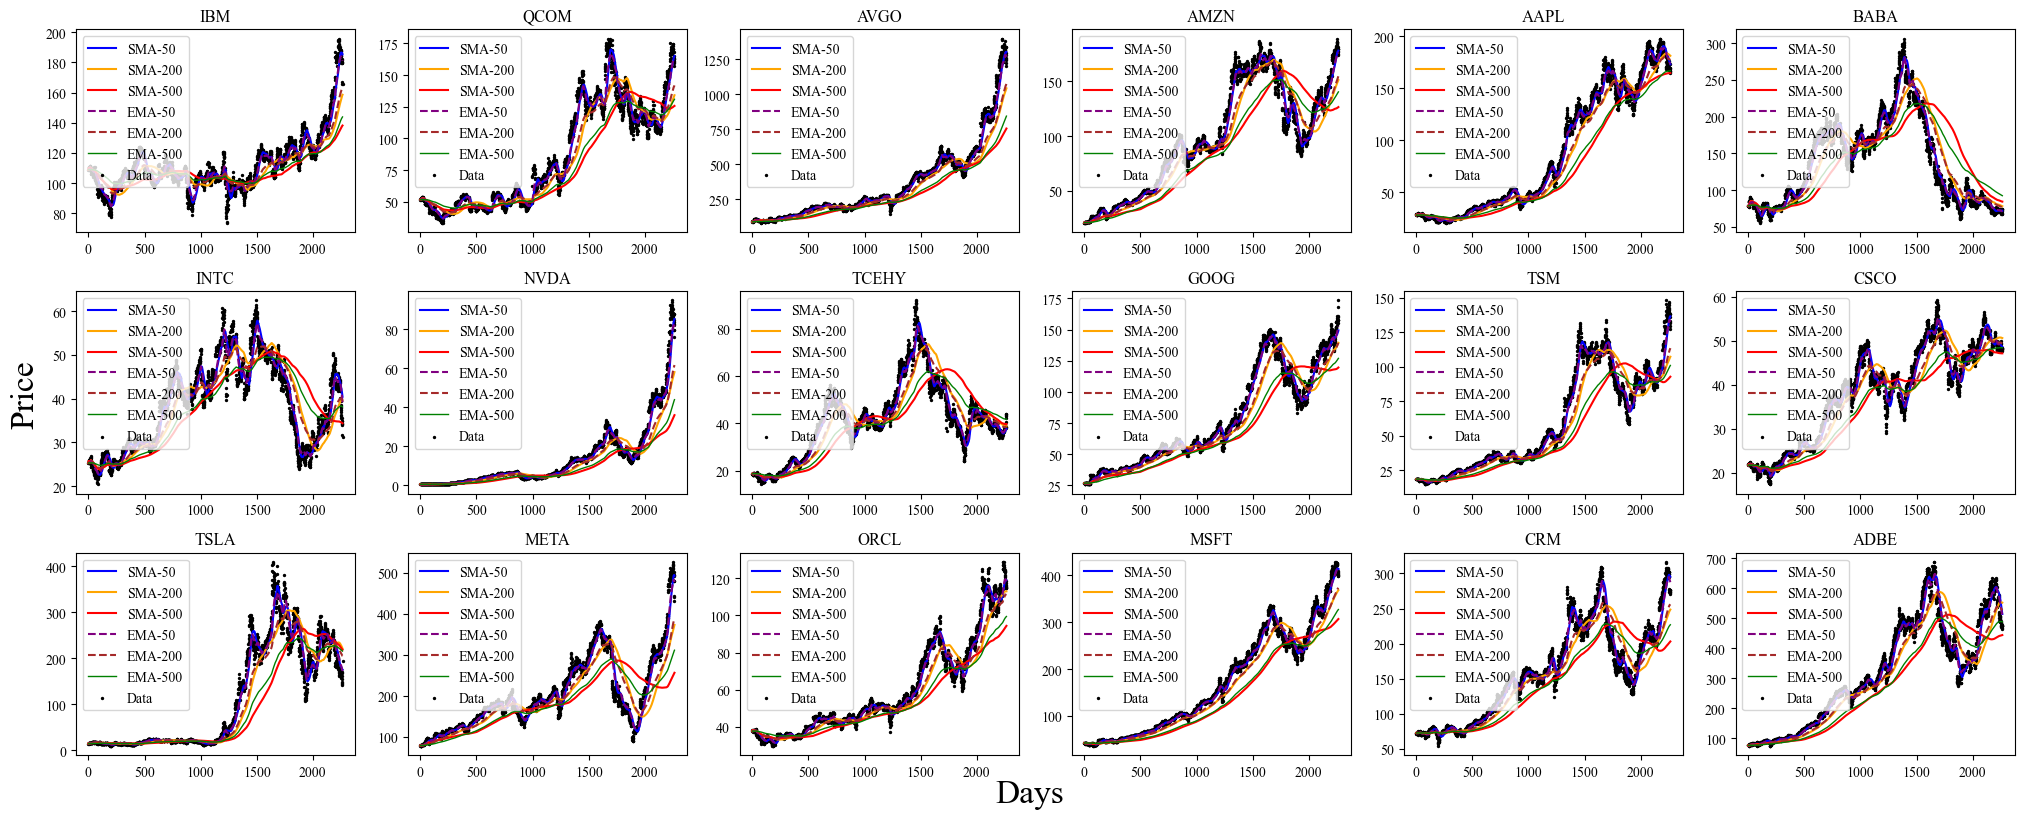

In [172]:
# subplot config
nrow = 3
ncol = 6
num_periods = 500
min_periods = 1
# Exponential smoothing parameter
tau = 1

fig, ax = plt.subplots(nrow, ncol, figsize=(20, 8))
for k in range(n):
    r, c = k % nrow, k // nrow
    tk = TICKERS[k]
    p = price_data[tk][1]
    
    # Compute moving averages
    sma_50 = p.rolling(window=50, min_periods=min_periods).mean()
    sma_200 = p.rolling(window=200, min_periods=min_periods).mean()
    sma = p.rolling(window=num_periods, min_periods=min_periods).mean()
    ema_50 = p.ewm(span=50, adjust=False).mean()
    ema_200 = p.ewm(span=200, adjust=False).mean()
    ema = p.ewm(span=num_periods, adjust=False).mean()
    
    # Plot the data
    ax[r, c].plot(sma_50, color="blue", label="SMA-50")
    ax[r, c].plot(sma_200, color="orange", label="SMA-200")
    ax[r, c].plot(sma, color="red", label="SMA-{}".format(num_periods))
    ax[r, c].plot(ema_50, color="purple", linestyle='--', label="EMA-50")
    ax[r, c].plot(ema_200, color="brown", linestyle='--', label="EMA-200")
    ax[r, c].plot(ema, lw=1.0, color="green", label="EMA-{}".format(num_periods))
    ax[r, c].scatter(range(len(p)), p, s=2, color="black", label="Data")
    ax[r, c].set_title(tk)
    ax[r, c].legend()
    
fig.tight_layout()
fig.text(0.5, -0.01, 'Days', ha='center', fontsize=24)
fig.text(-0.01, 0.5, 'Price', va='center', rotation='vertical', fontsize=24)

fig.savefig("./img/moving_avg.png", dpi=200);

### Correlation among stocks

Let the return series for stock $i$ be defined as $R_i(t)$. The correlation between stocks $i$ and $j$ can be computed as:
$$
    C_{ij} := \mathbb{E}[(R_i(t) - \mu_i(t))(R_j(t)-\mu_j(t))]
$$ where $\mu_i,\mu_j$ are the mean. This calculation is only valid if the return series have a stationary distribution in time. 

In [173]:
# organize return data 
return_data = pd.DataFrame()
return_data["Date"] = price_data["NVDA"][0]
# calculate log return 

for k in range(n):
    tk = TICKERS[k]
    price = price_data[tk][1]
    return_data[tk] = np.log(price) - np.log(price.shift(1))
return_data = return_data.dropna()
return_data.head()

,Date,IBM,INTC,TSLA,QCOM,NVDA,META,AVGO,TCEHY,ORCL,AMZN,GOOG,MSFT,AAPL,TSM,CRM,BABA,CSCO,ADBE
1,2015-05-01,0.013799,0.026377,-0.000088,0.006157,0.024473,0.002789,0.049409,-0.008279,0.017048,0.002581,0.001042,0.000411,0.029912,0.012200,0.007388,-0.001477,0.010352,0.004853
2,2015-05-04,0.001726,0.000299,0.019626,0.009310,-0.006173,-0.002281,-0.013445,0.005364,0.004946,0.000402,0.005340,-0.008669,-0.001941,-0.017123,-0.024284,-0.007171,0.001372,-0.007618
3,2015-05-05,-0.005129,-0.016710,0.010530,-0.010041,-0.025987,-0.015988,-0.036735,-0.022627,-0.015139,-0.004383,-0.018627,-0.013356,-0.022791,-0.001234,0.015934,-0.013115,-0.009645,-0.011270
4,2015-05-06,-0.010122,-0.012951,-0.010877,-0.008224,0.003172,0.006938,-0.000086,-0.012012,-0.015142,-0.004974,-0.012474,-0.028123,-0.006300,0.006566,0.014194,0.005767,0.002765,-0.006957
5,2015-05-07,0.005512,0.000621,0.027269,0.009102,0.017493,0.004216,0.047656,0.003518,0.005073,0.018393,0.012285,0.009034,0.006166,-0.003277,0.009844,0.072321,-0.005538,0.003351


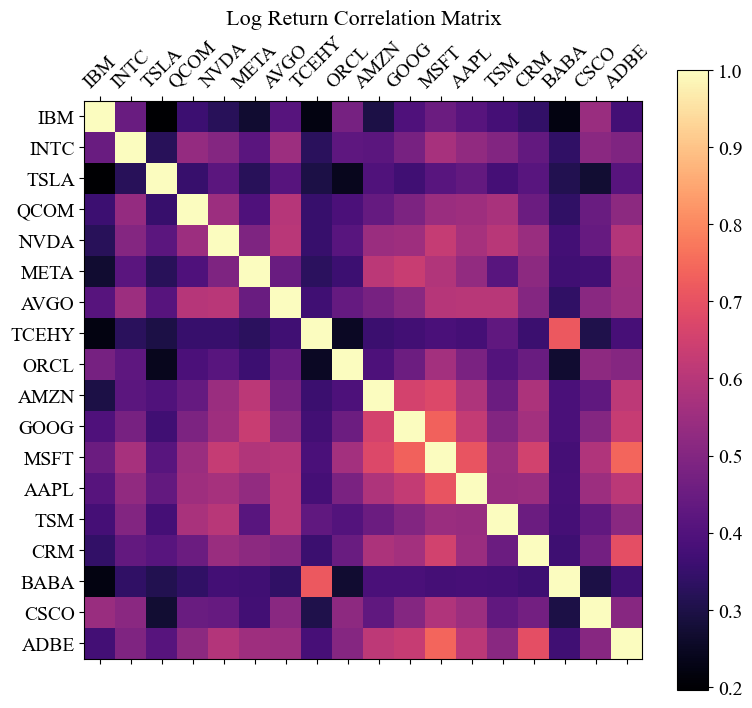

In [174]:
corrmat = return_data.corr(numeric_only=True)
f = plt.figure(figsize=(9, 8))
plt.matshow(corrmat, fignum=f.number, cmap='magma')
plt.xticks(range(return_data.select_dtypes(['number']).shape[1]), 
           return_data.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(return_data.select_dtypes(['number']).shape[1]), 
           return_data.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Log Return Correlation Matrix', fontsize=16);
plt.savefig("./img/correlation.png", dpi=200);

Eigenvalues of correlation matrix.

In [210]:
C = corrmat.values
#np.linalg.eig(C)

Are correlations higher among large caps?

In [211]:
data = [
    ["MSFT", 3.13, 'T'],
    ["AAPL", 2.65, 'T'],
    ["NVDA", 2.13, 'T'],
    ["AMZN", 1.88, 'T'],
    ["GOOG", 1.88, 'T'],
    ["META", 1.24, 'T'],
    ["TSM", 627.98, 'B'],
    ["AVGO", 602.57, 'B'],
    ["TSLA", 559.85, 'B'],
    ["TCEHY", 372.28, 'B'],
    ["ORCL", 322.10, 'B'],
    ["CRM", 261.14, 'B'],
    ["ADBE", 199.25, 'B'],
    ["CSCO", 190.23, 'B'],
    ["QCOM", 189.28, 'B'],
    ["INTC", 188.03, 'B'],
    ["BABA", 179.51, 'B'],
    ["IBM", 175.06, 'B']
]

# Adjust the market cap values based on the suffixes 'T' and 'B'
market_caps = [
    [ticker, value * (1e12 if suffix == 'T' else 1e9)]
    for ticker, value, suffix in data
]
market_caps

[['MSFT', 3130000000000.0],
 ['AAPL', 2650000000000.0],
 ['NVDA', 2130000000000.0],
 ['AMZN', 1880000000000.0],
 ['GOOG', 1880000000000.0],
 ['META', 1240000000000.0],
 ['TSM', 627980000000.0],
 ['AVGO', 602570000000.0],
 ['TSLA', 559850000000.0],
 ['TCEHY', 372280000000.0],
 ['ORCL', 322100000000.0],
 ['CRM', 261140000000.0],
 ['ADBE', 199250000000.0],
 ['CSCO', 190230000000.0],
 ['QCOM', 189280000000.0],
 ['INTC', 188030000000.0],
 ['BABA', 179510000000.0],
 ['IBM', 175060000000.0]]

In [218]:
# sort the 
sorted_caps = sorted(market_caps, key=lambda x: x[1], reverse=True)
unsorted_names = list(return_data.select_dtypes(['number']).columns)
sorted_names = [cap[0] for cap in sorted_caps]
# assign index
all_indices = {}
for i in range(len(sorted_names)):
    name = sorted_names[i]
    all_indices[name] = i
# assign indices for unsorted names
original_permutation = np.arange(len(sorted_names))
permutation = np.array([all_indices[name] for name in unsorted_names])
# permute matrix
C_sorted_by_cap = C.copy()
C_sorted_by_cap[original_permutation, :] = C_sorted_by_cap[permutation, :]
C_sorted_by_cap[:, original_permutation] = C_sorted_by_cap[:, permutation]

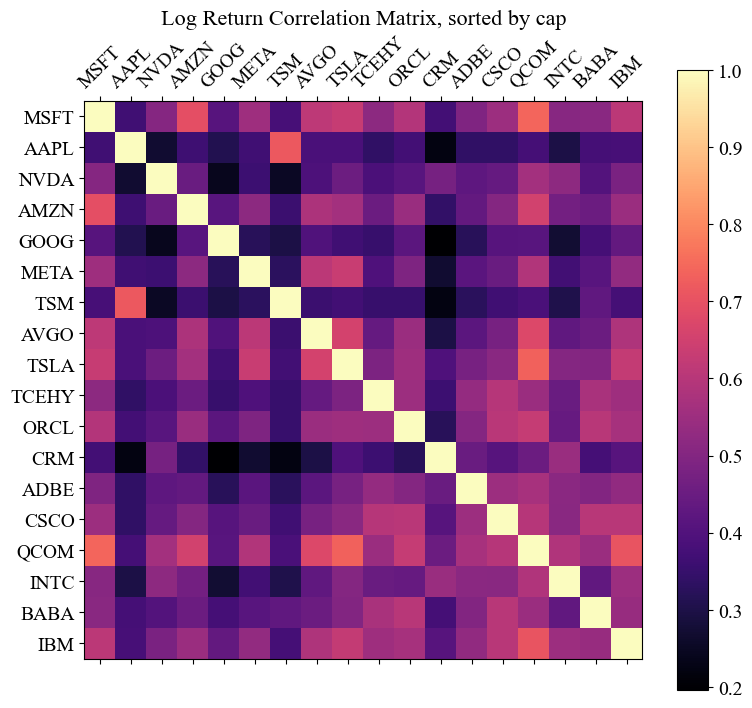

In [220]:
f = plt.figure(figsize=(9, 8))
plt.matshow(C_sorted_by_cap, fignum=f.number, cmap='magma')
plt.xticks(range(return_data.select_dtypes(['number']).shape[1]), 
           sorted_names, fontsize=14, rotation=45)
plt.yticks(range(return_data.select_dtypes(['number']).shape[1]), 
           sorted_names, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Log Return Correlation Matrix, sorted by cap', fontsize=16);
plt.savefig("./img/correlation_permuted.png", dpi=200);

In [213]:
np.arange(len(sorted_names))

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17])

### Buy-and-Hold Value-at-Risk

Since the return series is stationary, a natural approach is to resample the series and simulate buy-and-hold value at risk (VaR) using Monte Carlo. 

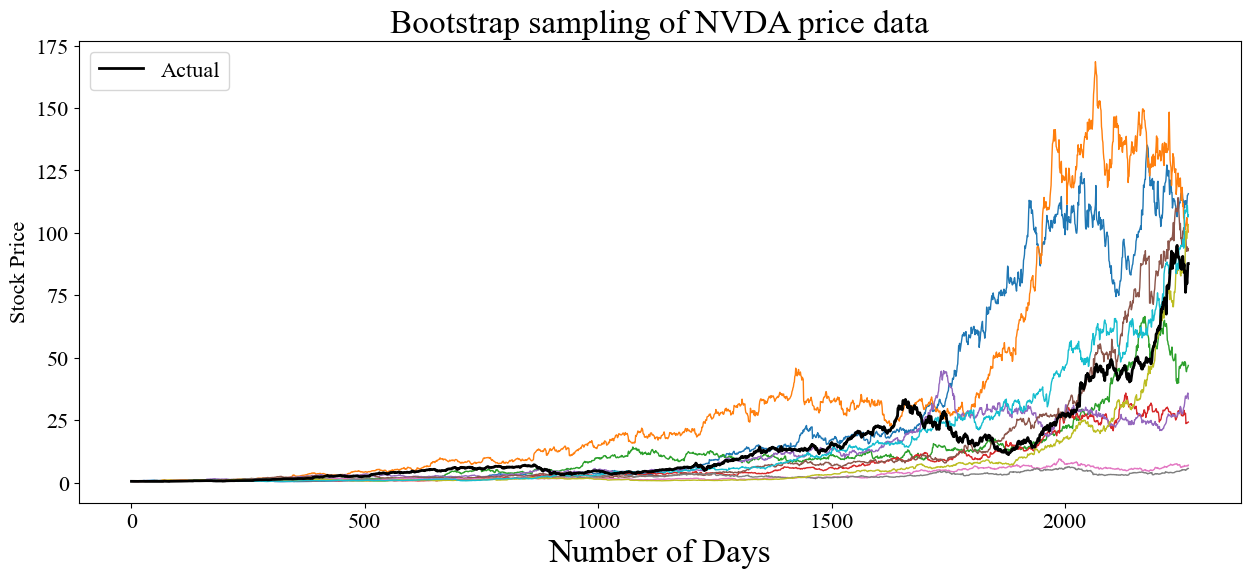

In [179]:
# reproducibility
np.random.seed(10);
# number of Monte Carlo trials
nmc = int(5e+3)
num_days = len(date)
mc_data = {}
for k in range(n):
    tk = TICKERS[k]
    # record initial value
    p0 = price_data[tk][1][0]
    p = np.zeros([nmc, num_days])
    p[:, 0] = p0
    # resample % returns with replacement
    ret = return_data[tk].values
    ret_resampled = np.random.choice(ret, size=(nmc, num_days-1), replace=True)
    # simulate price trajectories
    for day in range(1, num_days):
        p[:, day] = p[:, day-1] * (1. + ret_resampled[:, day-1])
    # save as data frame
    p = p.T 
    mc_data[tk] = pd.DataFrame(
        p, index=date
    );
# visualize for NVDA
tmp = "NVDA"
plt.figure(1, figsize=(15, 6));
for k in range(10):
    plt.plot(
        mc_data[tmp][k].values, lw=1.
    ); 
    plt.xlabel("Number of Days", fontsize=24); plt.ylabel("Stock Price", fontsize=16);
    plt.title(tmp);
# actual values
plt.plot(
    price_data["NVDA"][1].values, "-", lw=2.0, color="black", label="Actual"
);
plt.title("Bootstrap sampling of NVDA price data", fontsize=24)
plt.legend(fontsize=16);
plt.xticks(fontsize=16); plt.yticks(fontsize=16);
plt.savefig("./img/nvda_resample.png", dpi=200);

Let $L_t$ ($t\ge 1$) denote the net profit/loss after holding $t$ days. We define value at risk (VaR) as:
$$
    \text{VaR}(L_t;
    \alpha) := -\inf\{u: F_{L_t}(u) > \alpha\} 
$$

Namely:
* For a fixed level $\alpha$, $\text{VaR}(L_t;\alpha)$ denotes the $(1-\alpha)$-quantile of $-L_t$.
* There is an $\alpha$-probability of loss of more than $\text{VaR}(L_t;\alpha)$ 

The following block of code computes the VaR given a pre-defined $\alpha$ and $t$.

In [188]:
days_to_hold = np.arange(1, 11)
alpha = 0.05
var_data = {}
for k in range(n):
    tk = TICKERS[k]
    # compute value at risk
    all_var = np.zeros(len(days_to_hold))
    # initial investment value / initial price
    p0 = price_data[tk][1][0]
    for d in days_to_hold:
        # get holding period end time MC data
        pt = mc_data[tk].iloc[0+d, :].values
        # compute simple return 
        ret_mc = (pt - p0)/p0
        all_var[d-1] = np.quantile(-ret_mc, 1-alpha)
    # save simulated VaRs
    var_data[tk] = all_var

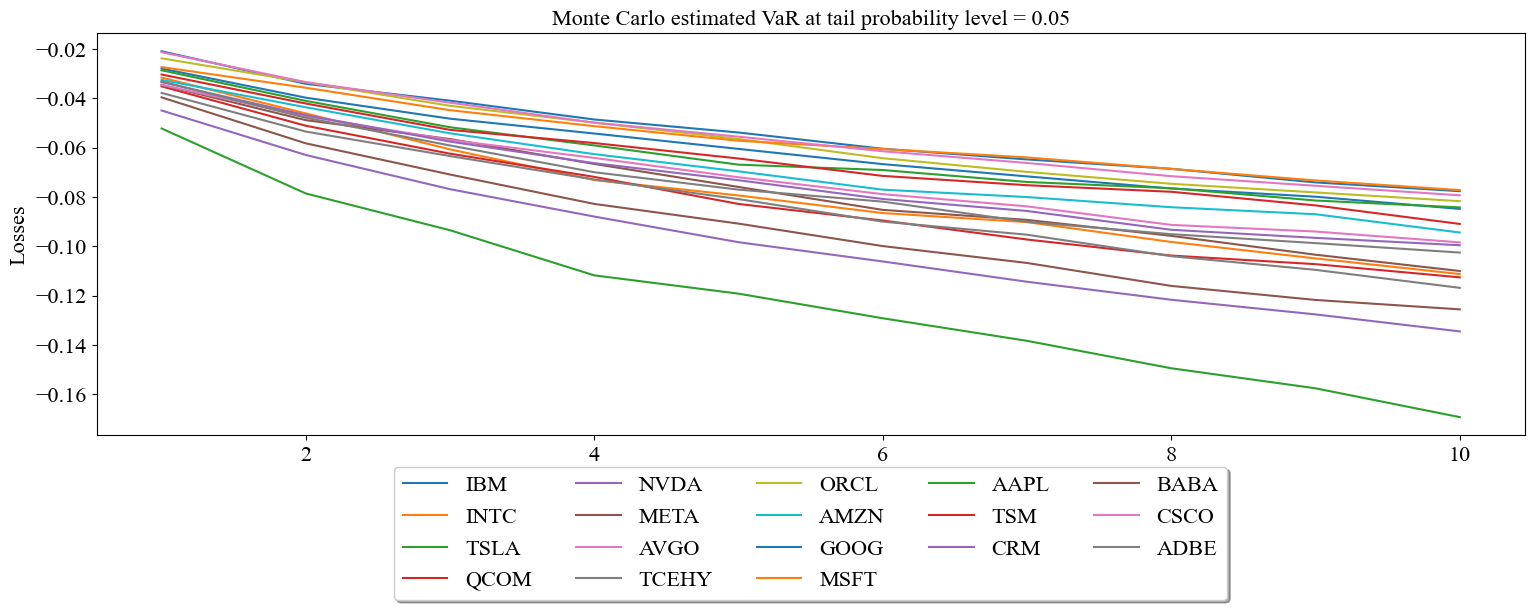

In [196]:
value_at_risk = pd.DataFrame(var_data)
# plot all value at risk over days to hold
plt.figure(1, figsize=(15, 6));
for k in range(n):
    tk = TICKERS[k]
    plt.plot(days_to_hold, -value_at_risk[tk].values, lw=1.5, label=tk);
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5, fontsize=16); plt.tight_layout();
plt.title("Monte Carlo estimated VaR at tail probability level = {}".format(alpha), fontsize=16);
plt.xticks(fontsize=16); plt.yticks(fontsize=16);
plt.xlabel("Days to hold", fontsize=16); 
plt.ylabel("Losses", fontsize=16);
plt.savefig("./img/monte_carlo_var.png", dpi=200, bbox_inches="tight")

The above value at risk plots may be suggestive of appropriate exit points. Negative VaRs suggest a high probability of profit. In general, the above plot suggests that holding long periods is more preferrable.

## Buy and hold VaR using Gaussian distribution

In [153]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from collections import defaultdict
all_days = [1, 2, 5, 10]
return_var = defaultdict(list)
for t in all_days:
    for k in range(n):
        tk = TICKERS[k]
        # get historical returns 
        r = return_data[tk]
        # compute standard deviation 
        sigma = r.std()
        # create normal 
        alpha = 0.05
        var = norm.ppf(alpha, 0.0, np.sqrt(t)*sigma)
        return_var[tk].append(var)
        # also append volatility for reference
        return_var[tk].append(np.sqrt(t)*sigma)

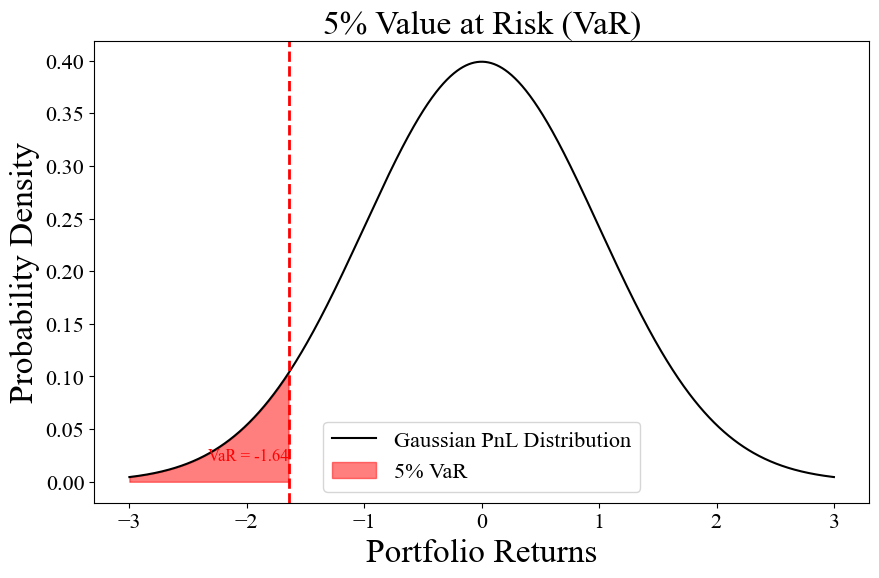

In [139]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
# Parameters
mu = 0  # Mean of the distribution
sigma = 1  # Standard deviation of the distribution
confidence_level = 0.05

# Value at Risk (VaR)
VaR = norm.ppf(confidence_level, mu, sigma)

# Generate data for the normal distribution curve
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 1000)
y = norm.pdf(x, mu, sigma)

# Plot the normal distribution curve
plt.figure(figsize=(10, 6))
plt.plot(x, y, label='Gaussian PnL Distribution', color="black")

# Shade the area representing the 5% VaR
x_fill = np.linspace(mu - 3*sigma, VaR, 1000)
y_fill = norm.pdf(x_fill, mu, sigma)
plt.fill_between(x_fill, y_fill, color='red', alpha=0.5, label='5% VaR')

# Add a vertical line at the VaR
plt.axvline(VaR, color='red', linestyle='--', linewidth=2)

# Annotations
plt.text(VaR, 0.02, f'VaR = {VaR:.2f}', horizontalalignment='right', fontsize=12, color='red')
plt.xlabel('Portfolio Returns', fontsize=24)
plt.ylabel('Probability Density', fontsize=24)
plt.title('5% Value at Risk (VaR)', fontsize=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)

# Show plot
plt.savefig("./img/var_illustrate.png", dpi=200, bbox_inches="tight")

### Measuring value at risk by drawdown

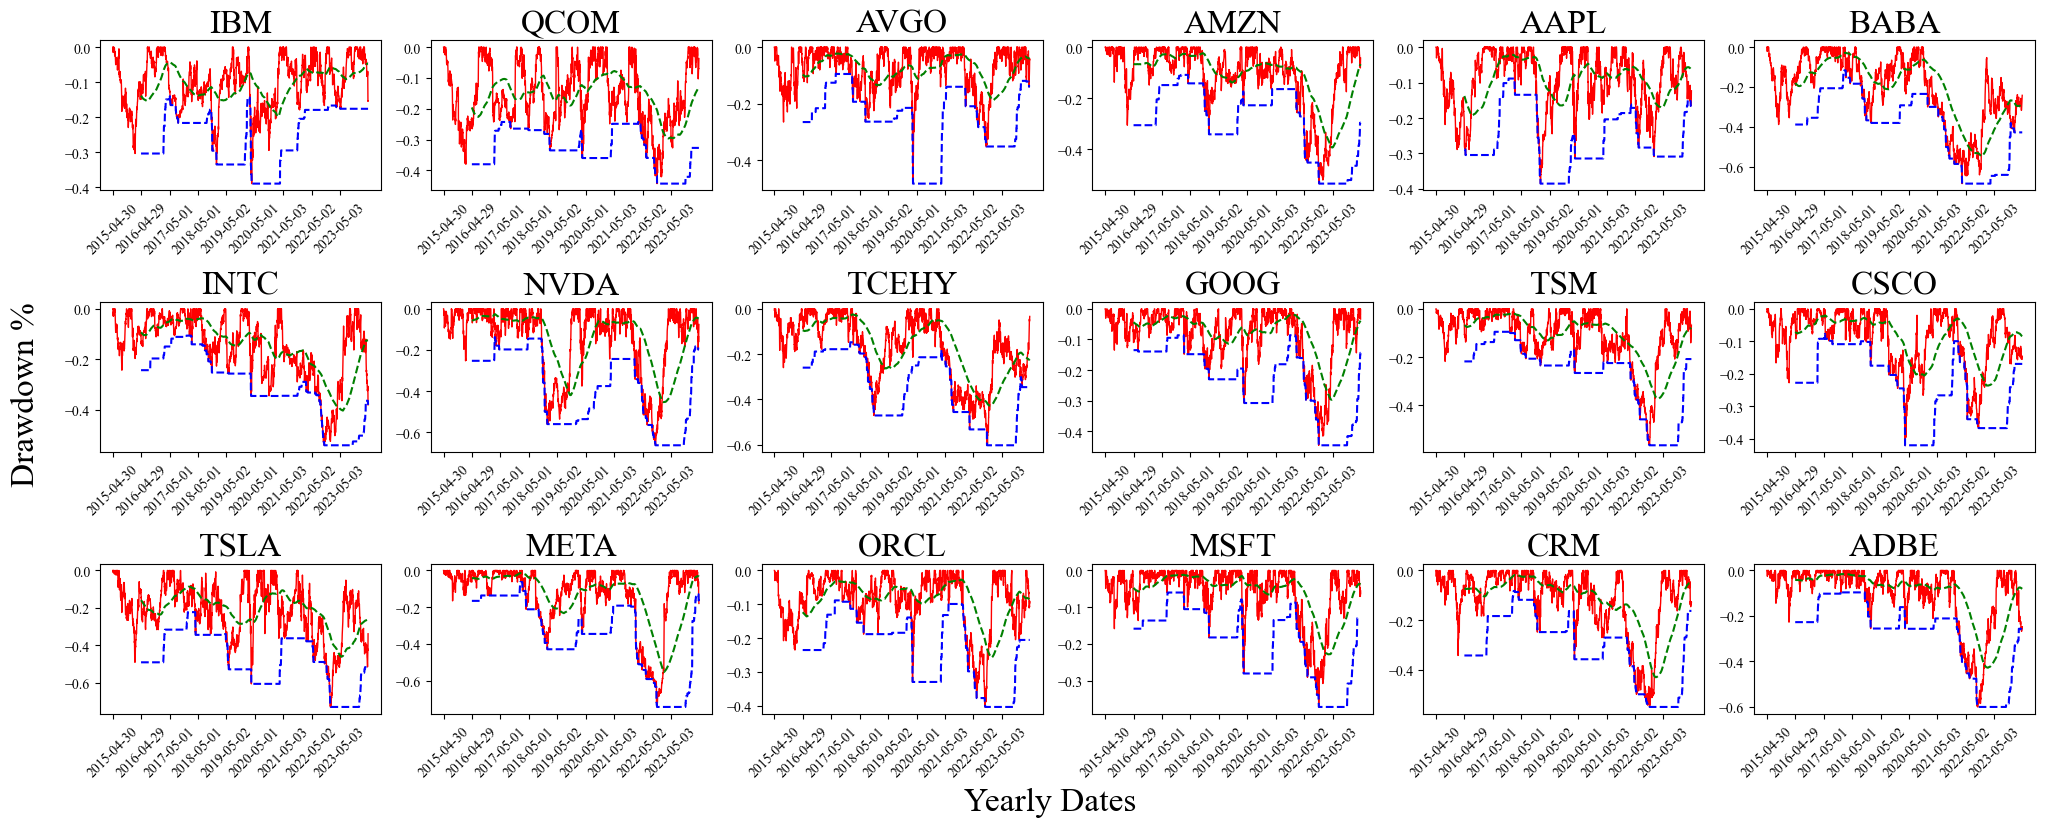

In [126]:
window = 252


fig, ax = plt.subplots(nrow, ncol, figsize=(20, 8))
for k in range(n):
    r, c = k % nrow, k // nrow
    tk = TICKERS[k]
    p = price_data[tk][1]
    yearly_date = price_data[tk][0][0::window].astype("str").values
    yearly_date_ind = np.arange(len(p))[0::window]
    # daily drawdown 
    rollmax = p.rolling(window=window, min_periods=1).max()
    daily_drawdown = p/rollmax - 1.0
    max_daily_drawdown = daily_drawdown.rolling(window, min_periods=window).min()
    avg_daily_drawdown = daily_drawdown.rolling(window, min_periods=window).mean()
    
    ax[r, c].plot(daily_drawdown, lw=1.0, color="red")
    ax[r, c].plot(max_daily_drawdown, "--", lw=1.5, color="blue")
    ax[r, c].plot(avg_daily_drawdown, "--", lw=1.5, color="green")
    ax[r, c].set_xticks(yearly_date_ind, yearly_date, rotation=45);
    ax[r, c].set_title(tk, fontsize=24)
fig.tight_layout()
fig.text(0.5, -0.02, 'Yearly Dates', ha='center', fontsize=24);
fig.text(-0.02, 0.5, 'Drawdown %', va='center', rotation='vertical', fontsize=24);
fig.savefig("./img/drawdown.png", dpi=200, bbox_inches="tight");